# Todo

* Use the pytorch RNN cell to get the same result
* Do the experiment over several random seeds
* done -- Play with the hidden size
* done -- Only finetune on the new data
* done -- Use MAE to compute the test loss
* done -- play with the sampling frequency

In [1]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import random

In [2]:
def generate_sequence(c=0.005, f_0=0, sf=10):
    """
    Generate a linear chirp signal. x is the time-domain signal and f is the instantaneous frequency
    """
    t = np.arange(0, 50, 1/sf)
    f = c * t + f_0
    phi = 2 * np.pi * (c / 2 * t**2 + f_0 * t)
    x = np.sin(phi)
    return x, f, t

In [3]:
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [4]:
class RNNCell(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNCell, self).__init__()
        self.hidden_size = hidden_size

        # Input to hidden
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        # Hidden to output
        self.h2o = nn.Linear(hidden_size, output_size)
        self.activation = nn.Tanh()

        self.initialize_weights()

    def forward(self, x, h):
        combined = torch.cat((x, h), dim=1)
        h_next = self.activation(self.i2h(combined))
        output = self.h2o(h_next)
        return output, h_next

    def initialize_weights(self):
        for layer in [self.i2h, self.h2o]:
            nn.init.xavier_uniform_(layer.weight)
            nn.init.zeros_(layer.bias)

In [32]:
def train_rnn(rnn, t, t_pretrain, num_epochs, ignore_pretrained_data=False):
    global X, Y

    input_seq, output_seq = X[:t], Y[:t]
    len_seq = len(input_seq)

    rnn.train()
    optimizer = torch.optim.Adam(rnn.parameters(), lr=0.001)
    criterion = nn.MSELoss(reduction='none')
    pbar = tqdm(range(num_epochs))

    for epoch in pbar:
        # initialize hidden state
        h = torch.zeros(1, hidden_size)
        
        # iterate over the sequence
        outs = []
        ys = []
        for k in range(len_seq):
            x = torch.tensor(input_seq[k]).view(1, -1).float()
            y = torch.tensor(output_seq[k]).view(1).float()
            out, h = rnn(x, h)
            outs.append(out)
            ys.append(y)
        outs = torch.stack(outs).squeeze(-1)
        ys = torch.stack(ys)
        
        # compute loss
        unmasked_losses = criterion(outs, ys)
        if ignore_pretrained_data:
            mask = torch.zeros_like(unmasked_losses, dtype=torch.bool)
            mask[t_pretrain:, :] = True
            masked_losses = unmasked_losses * mask.float()
            loss = masked_losses.mean()
        else:
            loss = unmasked_losses.mean()

        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        pbar.set_description(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()/len_seq:.4f}")
    return rnn

def evaluate(rnn, t):
    global X, Y
    
    input_seq, output_seq = X, Y
    rnn.eval()
    with torch.no_grad():
        h = torch.zeros(1, hidden_size)
        loss = []
        for k in range(len(input_seq)):
            x = torch.tensor(input_seq[k]).view(1, -1).float()
            y = torch.tensor(output_seq[k]).view(1).float()
            out, h = rnn(x, h)
            if k >= t:
                # loss.append(((out.view(1) - y)**2).item()) # MSE
                loss.append(abs((out.view(1) - y).item())) # MAE
    return np.mean(loss)

def pretrain(t, num_epochs):
    """
    pretrain the RNN on the first t steps of the sequence
    """
    global hidden_size, sample_rate

    t = int(t * sample_rate)

    set_seed(1996)
    rnn = RNNCell(1, hidden_size, 1)
    if t > 0:
        rnn = train_rnn(rnn, t, t, num_epochs, ignore_pretrained_data=False)
    error = evaluate(rnn, t)
    return rnn.state_dict(), error

def run_at_time(t, t_pretrain, pretrained_state_dict, num_epochs, ignore_pretrained_data=False, train=True):
    """
    We train an RNN to predict the instantaneous frequency in the future, given the time-domain value and the previous state.

    The RNN pretrained on the first `t_pretrain` steps of the sequence.

    When train == True: 
        The RNN is trained on the first t (including the pretraining data) steps of the sequence and evaluated on the future steps

    When train == False
        The RNN is not trained at all (no gradient steps)    
    """
    global sample_rate, hidden_size

    t = int(t * sample_rate)
    t_pretrain = int(t_pretrain * sample_rate)

    # initialize
    set_seed(1996)
    rnn = RNNCell(1, hidden_size, 1)
    rnn.load_state_dict(pretrained_state_dict)

    # train
    if train:
        rnn = train_rnn(rnn, t, t_pretrain, num_epochs, ignore_pretrained_data)

    # evaluate
    error = evaluate(rnn, t)
    
    return error

In [61]:
hidden_size = 8
num_pretrain_epochs = 100
num_finetune_epochs = 100
sample_rate = 10

X, Y, t = generate_sequence(sf=sample_rate)

In [62]:
t_pretrain = 10
t_list = np.arange(10+1, 25, 1)

err_1_list = []
err_2_list = []

pretrained_state_dict, initial_error = pretrain(t_pretrain, num_pretrain_epochs)

for t in t_list:
    print(f"t = {t}")
    err = run_at_time(t, t_pretrain, pretrained_state_dict, num_epochs=num_finetune_epochs, ignore_pretrained_data=False, train=True)
    err_1_list.append(err)

    err = run_at_time(t, t_pretrain, pretrained_state_dict, num_epochs=num_finetune_epochs, ignore_pretrained_data=False, train=False)
    err_2_list.append(err)

Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:02<00:00, 42.15it/s]


t = 11


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:02<00:00, 36.11it/s]


t = 12


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:03<00:00, 31.43it/s]


t = 13


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:03<00:00, 30.37it/s]


t = 14


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:03<00:00, 28.19it/s]


t = 15


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:03<00:00, 28.09it/s]


t = 16


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:03<00:00, 27.13it/s]


t = 17


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:04<00:00, 21.30it/s]


t = 18


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:04<00:00, 22.75it/s]


t = 19


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:04<00:00, 23.88it/s]


t = 20


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:04<00:00, 22.12it/s]


t = 21


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:04<00:00, 20.10it/s]


t = 22


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:05<00:00, 19.23it/s]


t = 23


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:05<00:00, 18.99it/s]


t = 24


Epoch 100/100, Loss: 0.0000: 100%|██████████| 100/100 [00:05<00:00, 17.22it/s]


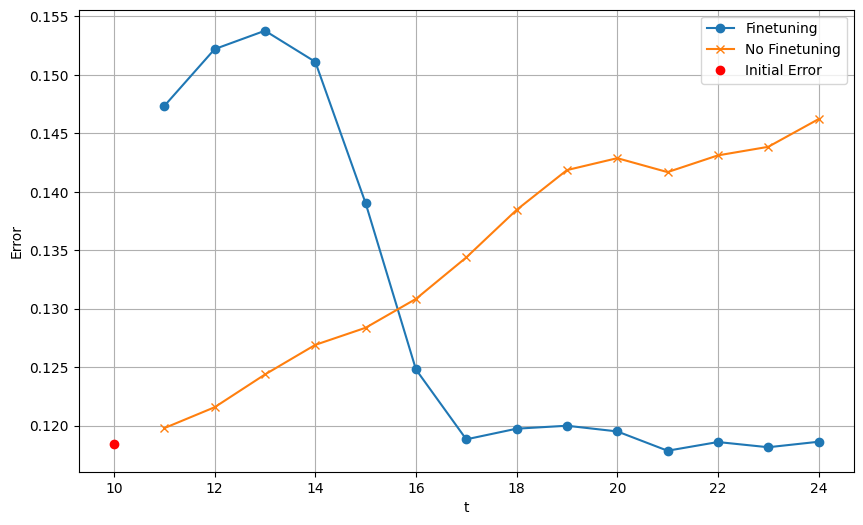

In [65]:
plt.figure(figsize=(10, 6))
plt.plot(t_list, err_1_list, label='Finetuning', marker='o')
plt.plot(t_list, err_2_list, label='No Finetuning', marker='x')
plt.plot([t_pretrain], [initial_error], 'ro', label='Initial Error')
plt.xlabel('t')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.show()

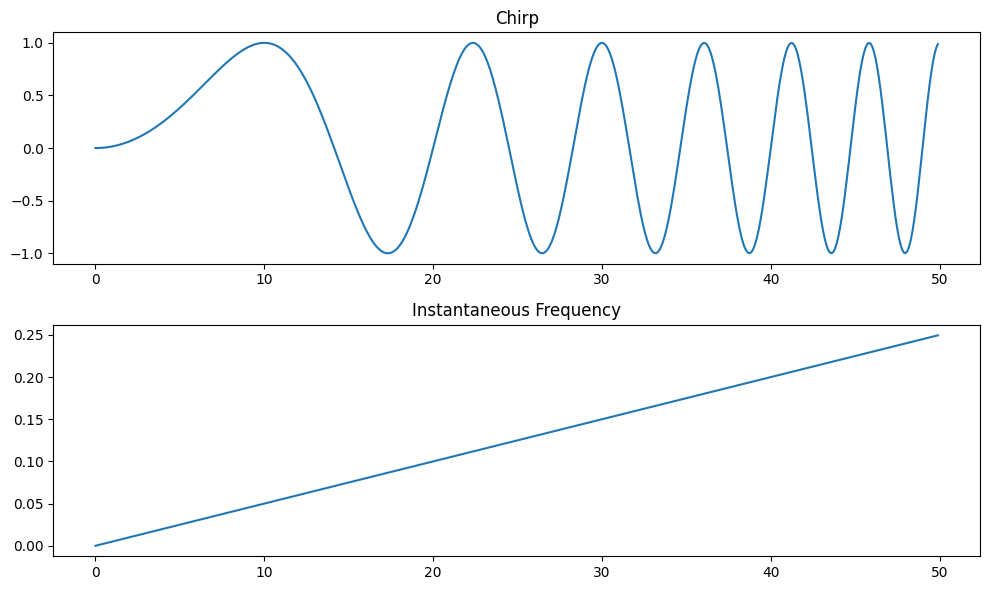

In [67]:
# plot the generated signal
fig, ax = plt.subplots(2, 1, figsize=(10, 6))
X, Y, t = generate_sequence(sf=sample_rate)
ax[0].plot(t, X)
ax[0].set_title('Chirp')
ax[1].plot(t, Y)
ax[1].set_title('Instantaneous Frequency')
fig.tight_layout()
plt.show()